# WeightWatcher demo (TensorFlow)

In [1]:
# Get rid of notebook left and right margins
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from __future__ import absolute_import, division, print_function
import sys
import tensorflow as tf

from ww import builder_tf, watcher
from tf_cifar10 import CIFAR10

e:\toolkits.win\anaconda3-5.1.0\envs\dlwin36tf170\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Visualize Graph

In [3]:
# CIFAR10 dataset and model
batch_size = 128
cifar10 = CIFAR10(batch_size=batch_size)

In [4]:
# Inspect data and labels
watcher.show("cifar10.train_data", cifar10.train_data)
watcher.show("cifar10.train_labels", cifar10.train_labels)
watcher.show("cifar10.test_data", cifar10.test_data)
watcher.show("cifar10.test_labels", cifar10.test_labels)

cifar10.train_data	Tensor  float64 (50000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.train_labels	Tensor  float64 (50000, 10)  min: 0.000  max: 1.000
cifar10.test_data	Tensor  float64 (10000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.test_labels	Tensor  float64 (10000, 10)  min: 0.000  max: 1.000


In [5]:
# Setup TF "graphing" session
sess = tf.Session()

In [6]:
# Setup placeholders/vars
inputs = tf.placeholder(tf.float32, shape=(batch_size, cifar10.img_size, cifar10.img_size, cifar10.num_channels))

In [7]:
# Build model
predictions = cifar10.model(inputs)

In [8]:
# Run the initializer
sess.run(tf.global_variables_initializer())

In [9]:
# Convert TF graph to directed graph
dg = builder_tf.build_tf_graph(tf.get_default_graph(), sess, predictions.op.name) # Nodes (78)

INFO:tensorflow:Froze 28 variables.
Converted 28 variables to const ops.


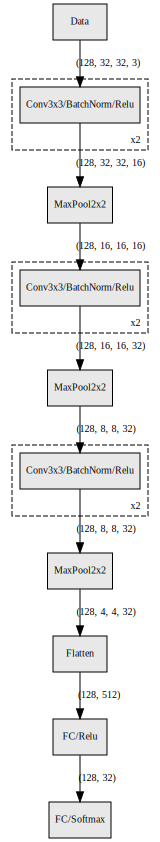

In [10]:
# Draw full graph
dg.draw_graph(simplify=True, output_shapes=True, verbose=False)

In [11]:
# Terminate "graphing" session
sess.close()
tf.reset_default_graph()

## Visualize Training Progress

In [12]:
# Setup TF training session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

In [13]:
# Setup placeholders/vars
inputs = tf.placeholder(tf.float32, shape=(batch_size, cifar10.img_size, cifar10.img_size, cifar10.num_channels))
outputs = tf.placeholder(tf.float32, shape=[batch_size, cifar10.num_classes])
g_step = tf.Variable(initial_value=0, trainable=False)

In [14]:
# Build model
predictions = cifar10.model(inputs)

In [15]:
# Setup loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=predictions, labels=outputs))
optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9).minimize(loss, global_step=g_step)

In [16]:
# Setup metric
accurate_preds = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(outputs, axis=1))
accuracy = tf.reduce_mean(tf.cast(accurate_preds, tf.float32))

In [17]:
# Instantiate watcher
w = watcher.Watcher()

In [18]:
# Visual customizations
w.legend={"loss": "Training Loss", "accuracy": "Training Accuracy"}

In [19]:
# Run the initializer
sess.run(tf.global_variables_initializer())

No handles with labels found to put in legend.


KeyboardInterrupt: 

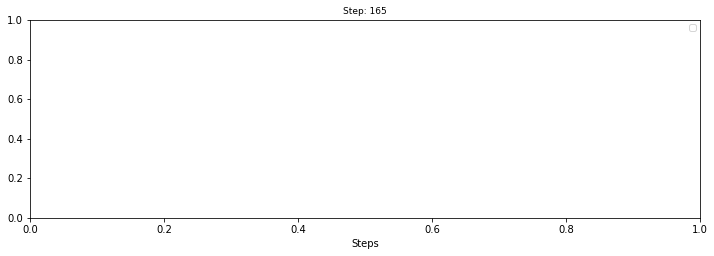

In [20]:
# Run training loop on GPU
epochs = 20
use_plots = True
if use_plots is False:
    _best_accuracy = -1
with tf.device('/gpu:0'): # Set to '/cpu:0' if you don't have a GPU
    for epoch in range(epochs):

        batches, _ = divmod(cifar10.train_len, batch_size)
        for batch in range(batches):

            # Fetch training samples
            _input = cifar10.train_data[batch*batch_size : (batch+1)*batch_size]
            _output = cifar10.train_labels[batch*batch_size : (batch+1)*batch_size]

            # Train model
            train_ops = [g_step, optimizer, loss, accuracy]
            step, _, _loss, _accuracy = sess.run(train_ops, feed_dict={inputs : _input, outputs : _output})

            # Print stats
            if batch & batch % 100 == 0:
                if use_plots:
                    # BUBUG - Generates `No handles with labels found to put in legend.` matplotlib  messages
                    w.step(step, loss=_loss, accuracy=_accuracy)
                    with w:
                        w.plot(["loss"])
                        w.plot(["accuracy"])
                else:
                    if _accuracy > _best_accuracy:
                        _best_accuracy = _accuracy
                        status_msg = '\r>>Step: {:>5} - Epoch: {:>2}/{:>2} - best batch acc: {:.4f} - loss: {:.4f}'
                        sys.stdout.write(status_msg.format(step, epoch+1, epochs, _accuracy, _loss))
                        sys.stdout.flush()

In [ ]:
# Terminate training session
sess.close()